In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len =70
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [5]:
x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

/tmp/ipykernel_4688/4138626256.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [6]:
x_train.size()

torch.Size([8019, 70, 300])

In [7]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([8019, 70])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_4688/2890137248.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_4688/2890137248.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_4688/2890137248.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_4688/2890137248.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/130, Train Loss: 1.4429087601010762, Val Loss: 0.8971074819564819, Val F1: 0.033856249098055194, Train F1: 0.03255768026014084


  2%|▋                                          | 2/130 [00:05<05:27,  2.56s/it]

Epoch 2/130, Train Loss: 0.8145123786396451, Val Loss: 0.7445921301841736, Val F1: 0.044713967843931494, Train F1: 0.037720830262312724


  2%|▉                                          | 3/130 [00:07<05:19,  2.52s/it]

Epoch 3/130, Train Loss: 0.7055962085723877, Val Loss: 0.6547126173973083, Val F1: 0.07776266631068467, Train F1: 0.06529546745065475


  3%|█▎                                         | 4/130 [00:10<05:12,  2.48s/it]

Epoch 4/130, Train Loss: 0.6326912490148393, Val Loss: 0.5963651537895203, Val F1: 0.10050739998388604, Train F1: 0.08365982931613096


  4%|█▋                                         | 5/130 [00:12<05:07,  2.46s/it]

Epoch 5/130, Train Loss: 0.5812137363448976, Val Loss: 0.5516266822814941, Val F1: 0.13135704668862022, Train F1: 0.11246279104460648


  5%|█▉                                         | 6/130 [00:14<05:03,  2.44s/it]

Epoch 6/130, Train Loss: 0.5424695232557872, Val Loss: 0.5195708870887756, Val F1: 0.16578595182235384, Train F1: 0.1544587859359725


  5%|██▎                                        | 7/130 [00:17<05:00,  2.44s/it]

Epoch 7/130, Train Loss: 0.5152255424431392, Val Loss: 0.500298023223877, Val F1: 0.19067506379461852, Train F1: 0.17933251136228995


  6%|██▋                                        | 8/130 [00:21<05:53,  2.90s/it]

Epoch 8/130, Train Loss: 0.49363800173714045, Val Loss: 0.482500821352005, Val F1: 0.20505353650075836, Train F1: 0.1935535370907239


  7%|██▉                                        | 9/130 [00:23<05:40,  2.82s/it]

Epoch 9/130, Train Loss: 0.479332134837196, Val Loss: 0.46998491883277893, Val F1: 0.20844965648595415, Train F1: 0.20740789531222353


  8%|███▏                                      | 10/130 [00:26<05:31,  2.77s/it]

Epoch 10/130, Train Loss: 0.4662910548467485, Val Loss: 0.45987826585769653, Val F1: 0.2220452409608719, Train F1: 0.21506285627498462


  8%|███▌                                      | 11/130 [00:29<05:24,  2.73s/it]

Epoch 11/130, Train Loss: 0.454683970837366, Val Loss: 0.4506741166114807, Val F1: 0.24039385730052826, Train F1: 0.2260983882893877


  9%|███▉                                      | 12/130 [00:31<05:18,  2.70s/it]

Epoch 12/130, Train Loss: 0.4456001141714671, Val Loss: 0.44573643803596497, Val F1: 0.25053892469576505, Train F1: 0.23576486683035822


 10%|████▏                                     | 13/130 [00:34<05:16,  2.71s/it]

Epoch 13/130, Train Loss: 0.43730938860348295, Val Loss: 0.43630746006965637, Val F1: 0.2520745542431462, Train F1: 0.24687622208054336


 11%|████▌                                     | 14/130 [00:37<05:11,  2.68s/it]

Epoch 14/130, Train Loss: 0.43022406716195366, Val Loss: 0.4331570565700531, Val F1: 0.2632983098160685, Train F1: 0.2560389306117543


 12%|████▊                                     | 15/130 [00:39<05:06,  2.67s/it]

Epoch 15/130, Train Loss: 0.4253699651786259, Val Loss: 0.42836299538612366, Val F1: 0.26430189472170856, Train F1: 0.2581530056068455


 12%|█████▏                                    | 16/130 [00:42<05:03,  2.66s/it]

Epoch 16/130, Train Loss: 0.41737643262696644, Val Loss: 0.4239092469215393, Val F1: 0.2654164661578664, Train F1: 0.26685913792240523


 13%|█████▍                                    | 17/130 [00:45<05:00,  2.66s/it]

Epoch 17/130, Train Loss: 0.4110730999992007, Val Loss: 0.4195699095726013, Val F1: 0.2671105591061454, Train F1: 0.27583304759667787


 14%|█████▊                                    | 18/130 [00:47<04:56,  2.65s/it]

Epoch 18/130, Train Loss: 0.40770525733629864, Val Loss: 0.41842809319496155, Val F1: 0.27331657196858666, Train F1: 0.27936132481142106


 15%|██████▏                                   | 19/130 [00:50<04:54,  2.65s/it]

Epoch 19/130, Train Loss: 0.40252450439665055, Val Loss: 0.41341033577919006, Val F1: 0.2838686217828763, Train F1: 0.28482494394253854


 15%|██████▍                                   | 20/130 [00:52<04:50,  2.64s/it]

Epoch 20/130, Train Loss: 0.39513918852049207, Val Loss: 0.40973949432373047, Val F1: 0.28762656757303473, Train F1: 0.292467993212325


 16%|██████▊                                   | 21/130 [00:55<04:48,  2.65s/it]

Epoch 21/130, Train Loss: 0.3919117630474151, Val Loss: 0.40887460112571716, Val F1: 0.27672229930626335, Train F1: 0.30041516817053543


 17%|███████                                   | 22/130 [00:58<04:46,  2.66s/it]

Epoch 22/130, Train Loss: 0.38627947086379644, Val Loss: 0.40508341789245605, Val F1: 0.3100074536861133, Train F1: 0.3042121349727571


 18%|███████▍                                  | 23/130 [01:00<04:44,  2.66s/it]

Epoch 23/130, Train Loss: 0.38291661464978777, Val Loss: 0.40063801407814026, Val F1: 0.29806038713748645, Train F1: 0.31180855961924936


 18%|███████▊                                  | 24/130 [01:03<04:44,  2.68s/it]

Epoch 24/130, Train Loss: 0.3814482513874296, Val Loss: 0.4024604260921478, Val F1: 0.30658910780343773, Train F1: 0.3169763329501076


 19%|████████                                  | 25/130 [01:06<04:40,  2.67s/it]

Epoch 25/130, Train Loss: 0.37593506489481243, Val Loss: 0.400089830160141, Val F1: 0.31688922830300387, Train F1: 0.32444604941543953


 20%|████████▍                                 | 26/130 [01:08<04:36,  2.66s/it]

Epoch 26/130, Train Loss: 0.37184218991370427, Val Loss: 0.39784687757492065, Val F1: 0.31837272068923345, Train F1: 0.3304104153291947


 21%|████████▋                                 | 27/130 [01:11<04:33,  2.66s/it]

Epoch 27/130, Train Loss: 0.36897550452323186, Val Loss: 0.3972305953502655, Val F1: 0.34049132055650994, Train F1: 0.3402125196506463


 22%|█████████                                 | 28/130 [01:14<04:31,  2.67s/it]

Epoch 28/130, Train Loss: 0.3639588989908733, Val Loss: 0.3940335512161255, Val F1: 0.33959377434074733, Train F1: 0.34269627303886957


 22%|█████████▎                                | 29/130 [01:16<04:28,  2.66s/it]

Epoch 29/130, Train Loss: 0.36233260044975885, Val Loss: 0.39604440331459045, Val F1: 0.35173023611747023, Train F1: 0.3501235195849113


 23%|█████████▋                                | 30/130 [01:19<04:24,  2.65s/it]

Epoch 30/130, Train Loss: 0.35812263356314766, Val Loss: 0.3921070992946625, Val F1: 0.34216684373675926, Train F1: 0.3506713944278928


 24%|██████████                                | 31/130 [01:22<04:21,  2.64s/it]

Epoch 31/130, Train Loss: 0.3548023185086629, Val Loss: 0.3922743797302246, Val F1: 0.3343324301743429, Train F1: 0.3579300283774208


 25%|██████████▎                               | 32/130 [01:24<04:18,  2.64s/it]

Epoch 32/130, Train Loss: 0.35218673140283613, Val Loss: 0.3928002715110779, Val F1: 0.355209293691048, Train F1: 0.364294679455497


 25%|██████████▋                               | 33/130 [01:29<05:16,  3.26s/it]

Epoch 33/130, Train Loss: 0.34855985026510933, Val Loss: 0.3936867117881775, Val F1: 0.3434318281218527, Train F1: 0.36689586388408685


 26%|██████████▉                               | 34/130 [01:34<05:56,  3.71s/it]

Epoch 34/130, Train Loss: 0.3464854761721596, Val Loss: 0.39520934224128723, Val F1: 0.3476394047785476, Train F1: 0.37100521211857745


 27%|███████████▎                              | 35/130 [01:39<06:24,  4.05s/it]

Epoch 35/130, Train Loss: 0.3422042069927094, Val Loss: 0.40100255608558655, Val F1: 0.3429940450862153, Train F1: 0.3756417464388629


 28%|███████████▋                              | 36/130 [01:44<06:55,  4.42s/it]

Epoch 36/130, Train Loss: 0.3402405423777444, Val Loss: 0.3892112076282501, Val F1: 0.3616840848552083, Train F1: 0.3838297417806959


 28%|███████████▉                              | 37/130 [01:46<05:54,  3.81s/it]

Epoch 37/130, Train Loss: 0.33715775325184777, Val Loss: 0.3922104835510254, Val F1: 0.3677671774242668, Train F1: 0.38098563092292825


 29%|████████████▎                             | 38/130 [01:50<05:44,  3.74s/it]

Epoch 38/130, Train Loss: 0.33546046321354217, Val Loss: 0.3995908200740814, Val F1: 0.35961843826116074, Train F1: 0.38979625275938284


 30%|████████████▌                             | 39/130 [01:53<05:11,  3.42s/it]

Epoch 39/130, Train Loss: 0.3324853058845278, Val Loss: 0.3927953839302063, Val F1: 0.35881992026097403, Train F1: 0.39741131094368987


 31%|████████████▉                             | 40/130 [01:55<04:47,  3.19s/it]

Epoch 40/130, Train Loss: 0.3279249143032801, Val Loss: 0.4058474600315094, Val F1: 0.3500952052731065, Train F1: 0.39551892158573965


 32%|█████████████▏                            | 41/130 [01:58<04:29,  3.03s/it]

Epoch 41/130, Train Loss: 0.32562330838233705, Val Loss: 0.4020957052707672, Val F1: 0.36987020865904074, Train F1: 0.39960480770328677


 32%|█████████████▌                            | 42/130 [02:01<04:17,  2.92s/it]

Epoch 42/130, Train Loss: 0.3226121285605052, Val Loss: 0.40498584508895874, Val F1: 0.36719045537644807, Train F1: 0.40880156495150277


 33%|█████████████▉                            | 43/130 [02:03<04:08,  2.85s/it]

Epoch 43/130, Train Loss: 0.3203909075449383, Val Loss: 0.3939892053604126, Val F1: 0.3687210885501714, Train F1: 0.4117622225899471


 34%|██████████████▏                           | 44/130 [02:06<04:00,  2.80s/it]

Epoch 44/130, Train Loss: 0.32097013176433625, Val Loss: 0.3965569734573364, Val F1: 0.36442620430753403, Train F1: 0.40711108232959736


 35%|██████████████▌                           | 45/130 [02:09<03:54,  2.76s/it]

Epoch 45/130, Train Loss: 0.3164957151526496, Val Loss: 0.4098605215549469, Val F1: 0.3537193422870835, Train F1: 0.4148004907632583


 35%|██████████████▊                           | 46/130 [02:11<03:51,  2.75s/it]

Epoch 46/130, Train Loss: 0.3129183044509282, Val Loss: 0.40322622656822205, Val F1: 0.37221232479479055, Train F1: 0.42188480007331464


 36%|███████████████▏                          | 47/130 [02:14<03:45,  2.72s/it]

Epoch 47/130, Train Loss: 0.3099129606807043, Val Loss: 0.39320263266563416, Val F1: 0.3817966829454295, Train F1: 0.4245412180618192


 37%|███████████████▌                          | 48/130 [02:17<03:41,  2.70s/it]

Epoch 48/130, Train Loss: 0.30723639187358676, Val Loss: 0.41141003370285034, Val F1: 0.3817092879463621, Train F1: 0.4306026332087205


 38%|███████████████▊                          | 49/130 [02:19<03:37,  2.69s/it]

Epoch 49/130, Train Loss: 0.30623795919948155, Val Loss: 0.3973149359226227, Val F1: 0.3815969416057176, Train F1: 0.4346217988691774


 38%|████████████████▏                         | 50/130 [02:22<03:33,  2.67s/it]

Epoch 50/130, Train Loss: 0.3026531118722189, Val Loss: 0.41518810391426086, Val F1: 0.38377774908408874, Train F1: 0.43822957082254627


 39%|████████████████▍                         | 51/130 [02:25<03:31,  2.68s/it]

Epoch 51/130, Train Loss: 0.300390976288962, Val Loss: 0.39753586053848267, Val F1: 0.385134754409297, Train F1: 0.4410809163661147


 40%|████████████████▊                         | 52/130 [02:27<03:28,  2.67s/it]

Epoch 52/130, Train Loss: 0.2973287756007815, Val Loss: 0.4032400846481323, Val F1: 0.37292741599322804, Train F1: 0.4456317850914043


 41%|█████████████████                         | 53/130 [02:30<03:25,  2.66s/it]

Epoch 53/130, Train Loss: 0.29829626684151, Val Loss: 0.404220312833786, Val F1: 0.3904834987192994, Train F1: 0.44684509297430464


 42%|█████████████████▍                        | 54/130 [02:33<03:22,  2.66s/it]

Epoch 54/130, Train Loss: 0.2908755864888903, Val Loss: 0.41931694746017456, Val F1: 0.3770461945476887, Train F1: 0.4531531328336525


 42%|█████████████████▊                        | 55/130 [02:35<03:20,  2.67s/it]

Epoch 55/130, Train Loss: 0.28753300697084455, Val Loss: 0.4231516420841217, Val F1: 0.38286370259538294, Train F1: 0.46196868436679206


 43%|██████████████████                        | 56/130 [02:38<03:17,  2.67s/it]

Epoch 56/130, Train Loss: 0.28656374509372406, Val Loss: 0.40610986948013306, Val F1: 0.385418514068619, Train F1: 0.4622937527335242


 44%|██████████████████▍                       | 57/130 [02:41<03:16,  2.69s/it]

Epoch 57/130, Train Loss: 0.2850798597884557, Val Loss: 0.42115482687950134, Val F1: 0.39118171565642545, Train F1: 0.46501771833166994


 45%|██████████████████▋                       | 58/130 [02:43<03:12,  2.67s/it]

Epoch 58/130, Train Loss: 0.28128733284889706, Val Loss: 0.4134986996650696, Val F1: 0.3813146521773973, Train F1: 0.4670106112785063


 45%|███████████████████                       | 59/130 [02:46<03:09,  2.67s/it]

Epoch 59/130, Train Loss: 0.27799761366276515, Val Loss: 0.4360823631286621, Val F1: 0.36804061884277284, Train F1: 0.4710750582103856


 46%|███████████████████▍                      | 60/130 [02:49<03:06,  2.66s/it]

Epoch 60/130, Train Loss: 0.27579626133517615, Val Loss: 0.4377521276473999, Val F1: 0.38381562020588966, Train F1: 0.47291228833442034


 47%|███████████████████▋                      | 61/130 [02:51<03:03,  2.66s/it]

Epoch 61/130, Train Loss: 0.2729339154939803, Val Loss: 0.43637537956237793, Val F1: 0.3779583103768502, Train F1: 0.4801359928206387


 48%|████████████████████                      | 62/130 [02:54<03:01,  2.67s/it]

Epoch 62/130, Train Loss: 0.27240732099328724, Val Loss: 0.42641332745552063, Val F1: 0.3899917782649505, Train F1: 0.4788342864909528


 48%|████████████████████▎                     | 63/130 [02:57<02:58,  2.67s/it]

Epoch 63/130, Train Loss: 0.26812779974369777, Val Loss: 0.43863654136657715, Val F1: 0.3869804633381508, Train F1: 0.4857524866450969


 49%|████████████████████▋                     | 64/130 [02:59<02:55,  2.67s/it]

Epoch 64/130, Train Loss: 0.26433052950435215, Val Loss: 0.4320935606956482, Val F1: 0.39367543980364056, Train F1: 0.49685361762344565


 50%|█████████████████████                     | 65/130 [03:02<02:53,  2.67s/it]

Epoch 65/130, Train Loss: 0.26302623228421285, Val Loss: 0.4424286186695099, Val F1: 0.39061317100913046, Train F1: 0.4963765763144075


 51%|█████████████████████▎                    | 66/130 [03:05<02:50,  2.67s/it]

Epoch 66/130, Train Loss: 0.2577253338836488, Val Loss: 0.44065216183662415, Val F1: 0.38762068391808036, Train F1: 0.500744323133528


 52%|█████████████████████▋                    | 67/130 [03:07<02:48,  2.67s/it]

Epoch 67/130, Train Loss: 0.2567291512848839, Val Loss: 0.434033066034317, Val F1: 0.39460797029449846, Train F1: 0.5015174104373272


 52%|█████████████████████▉                    | 68/130 [03:10<02:48,  2.71s/it]

Epoch 68/130, Train Loss: 0.26958712604310775, Val Loss: 0.43595606088638306, Val F1: 0.3876370849199789, Train F1: 0.4934142224976165


 53%|██████████████████████▎                   | 69/130 [03:13<02:44,  2.69s/it]

Epoch 69/130, Train Loss: 0.2544151431038266, Val Loss: 0.4414232075214386, Val F1: 0.4025593029753977, Train F1: 0.512602156796908


 54%|██████████████████████▌                   | 70/130 [03:15<02:40,  2.68s/it]

Epoch 70/130, Train Loss: 0.24875456686057743, Val Loss: 0.44560059905052185, Val F1: 0.3794374728424192, Train F1: 0.5130841240061436


 55%|██████████████████████▉                   | 71/130 [03:18<02:37,  2.68s/it]

Epoch 71/130, Train Loss: 0.24727359650627015, Val Loss: 0.4401242434978485, Val F1: 0.3954187567353638, Train F1: 0.5158273984538251


 55%|███████████████████████▎                  | 72/130 [03:21<02:37,  2.72s/it]

Epoch 72/130, Train Loss: 0.24912882939217582, Val Loss: 0.4521452486515045, Val F1: 0.392444958045844, Train F1: 0.5185333724132765


 56%|███████████████████████▌                  | 73/130 [03:24<02:34,  2.71s/it]

Epoch 73/130, Train Loss: 0.2409873361152316, Val Loss: 0.4460051357746124, Val F1: 0.39641702502107146, Train F1: 0.5283548787852448


 57%|███████████████████████▉                  | 74/130 [03:26<02:30,  2.70s/it]

Epoch 74/130, Train Loss: 0.23869658699111332, Val Loss: 0.47452986240386963, Val F1: 0.38735609623907763, Train F1: 0.5276977831456491


 58%|████████████████████████▏                 | 75/130 [03:29<02:28,  2.69s/it]

Epoch 75/130, Train Loss: 0.23511098301599895, Val Loss: 0.4796714186668396, Val F1: 0.3908922212963137, Train F1: 0.5388597776544841


 58%|████████████████████████▌                 | 76/130 [03:32<02:24,  2.68s/it]

Epoch 76/130, Train Loss: 0.2318011037414036, Val Loss: 0.4916982054710388, Val F1: 0.38833837384765757, Train F1: 0.5392520651122954


 59%|████████████████████████▉                 | 77/130 [03:34<02:22,  2.68s/it]

Epoch 77/130, Train Loss: 0.22960352353633395, Val Loss: 0.47570937871932983, Val F1: 0.39116132858003777, Train F1: 0.5418033037300066


 60%|█████████████████████████▏                | 78/130 [03:37<02:19,  2.68s/it]

Epoch 78/130, Train Loss: 0.2272838153063305, Val Loss: 0.4684494733810425, Val F1: 0.4049920924734117, Train F1: 0.5466618707538241


 61%|█████████████████████████▌                | 79/130 [03:40<02:18,  2.71s/it]

Epoch 79/130, Train Loss: 0.22460308789260805, Val Loss: 0.4915323853492737, Val F1: 0.3825649411243302, Train F1: 0.5537314596471926


 62%|█████████████████████████▊                | 80/130 [03:42<02:14,  2.69s/it]

Epoch 80/130, Train Loss: 0.22331293163791535, Val Loss: 0.4787714183330536, Val F1: 0.3883815076048049, Train F1: 0.5553714050261821


 62%|██████████████████████████▏               | 81/130 [03:45<02:11,  2.69s/it]

Epoch 81/130, Train Loss: 0.21962415864543308, Val Loss: 0.49843770265579224, Val F1: 0.39000460633089623, Train F1: 0.5617990056404102


 63%|██████████████████████████▍               | 82/130 [03:48<02:09,  2.69s/it]

Epoch 82/130, Train Loss: 0.21876968774530622, Val Loss: 0.5014305114746094, Val F1: 0.3804717096454261, Train F1: 0.56375027804004


 64%|██████████████████████████▊               | 83/130 [03:50<02:06,  2.69s/it]

Epoch 83/130, Train Loss: 0.21673541196755, Val Loss: 0.5263949036598206, Val F1: 0.3854630645610068, Train F1: 0.5706380170702932


 65%|███████████████████████████▏              | 84/130 [03:53<02:03,  2.69s/it]

Epoch 84/130, Train Loss: 0.21931601209299906, Val Loss: 0.5036224722862244, Val F1: 0.39907016642349685, Train F1: 0.5670206114918973


 65%|███████████████████████████▍              | 85/130 [03:56<02:01,  2.70s/it]

Epoch 85/130, Train Loss: 0.20986784758075835, Val Loss: 0.5277898907661438, Val F1: 0.39027514471672825, Train F1: 0.5789327415997942


 66%|███████████████████████████▊              | 86/130 [03:59<01:58,  2.70s/it]

Epoch 86/130, Train Loss: 0.22452879874479204, Val Loss: 0.48701369762420654, Val F1: 0.3824846124185303, Train F1: 0.5647923607112417


 67%|████████████████████████████              | 87/130 [04:01<01:55,  2.69s/it]

Epoch 87/130, Train Loss: 0.2159802346002488, Val Loss: 0.518986701965332, Val F1: 0.38896628188794646, Train F1: 0.5720779364127292


 68%|████████████████████████████▍             | 88/130 [04:04<01:52,  2.69s/it]

Epoch 88/130, Train Loss: 0.20383604722363607, Val Loss: 0.5209291577339172, Val F1: 0.3963064479042076, Train F1: 0.5882916644546796


 68%|████████████████████████████▊             | 89/130 [04:07<01:50,  2.69s/it]

Epoch 89/130, Train Loss: 0.20044138294363778, Val Loss: 0.5275251269340515, Val F1: 0.3949257285127799, Train F1: 0.5911293066488412


 69%|█████████████████████████████             | 90/130 [04:09<01:48,  2.71s/it]

Epoch 90/130, Train Loss: 0.19687432665673513, Val Loss: 0.5336604714393616, Val F1: 0.392096188327001, Train F1: 0.601441648762364


 70%|█████████████████████████████▍            | 91/130 [04:12<01:45,  2.69s/it]

Epoch 91/130, Train Loss: 0.19569588417098635, Val Loss: 0.5348008275032043, Val F1: 0.3911690751892647, Train F1: 0.6087259372727222


 71%|█████████████████████████████▋            | 92/130 [04:15<01:42,  2.69s/it]

Epoch 92/130, Train Loss: 0.19256693526865945, Val Loss: 0.5525384545326233, Val F1: 0.38496921394956135, Train F1: 0.6113583586171627


 72%|██████████████████████████████            | 93/130 [04:17<01:39,  2.68s/it]

Epoch 93/130, Train Loss: 0.18963927692837185, Val Loss: 0.5554733872413635, Val F1: 0.38665283173538123, Train F1: 0.6178603697806522


 72%|██████████████████████████████▎           | 94/130 [04:20<01:36,  2.68s/it]

Epoch 94/130, Train Loss: 0.1884480355277894, Val Loss: 0.5412502288818359, Val F1: 0.3914728233403667, Train F1: 0.6235791862133653


 73%|██████████████████████████████▋           | 95/130 [04:23<01:33,  2.67s/it]

Epoch 95/130, Train Loss: 0.18645330293784065, Val Loss: 0.5662391185760498, Val F1: 0.3823903044684584, Train F1: 0.6277436675070618


 74%|███████████████████████████████           | 96/130 [04:25<01:30,  2.67s/it]

Epoch 96/130, Train Loss: 0.18570075645333245, Val Loss: 0.543208658695221, Val F1: 0.3911292047353485, Train F1: 0.6255659602988327


 75%|███████████████████████████████▎          | 97/130 [04:28<01:28,  2.67s/it]

Epoch 97/130, Train Loss: 0.18218377090635754, Val Loss: 0.5601488351821899, Val F1: 0.3794301046313438, Train F1: 0.6300499827886394


 75%|███████████████████████████████▋          | 98/130 [04:31<01:25,  2.67s/it]

Epoch 98/130, Train Loss: 0.17970200001247347, Val Loss: 0.5797224044799805, Val F1: 0.3780629663848214, Train F1: 0.6451964523445273


 76%|███████████████████████████████▉          | 99/130 [04:33<01:22,  2.67s/it]

Epoch 99/130, Train Loss: 0.17772176365057626, Val Loss: 0.5846778154373169, Val F1: 0.38111534507119377, Train F1: 0.6415319727509115


 77%|███████████████████████████████▌         | 100/130 [04:36<01:20,  2.69s/it]

Epoch 100/130, Train Loss: 0.1778739799582769, Val Loss: 0.5770392417907715, Val F1: 0.3899828833825045, Train F1: 0.6455450510657229


 78%|███████████████████████████████▊         | 101/130 [04:39<01:19,  2.75s/it]

Epoch 101/130, Train Loss: 0.17325948178768158, Val Loss: 0.6112727522850037, Val F1: 0.37766798143724845, Train F1: 0.6553610247948691


 78%|████████████████████████████████▏        | 102/130 [04:42<01:16,  2.75s/it]

Epoch 102/130, Train Loss: 0.1704925163870766, Val Loss: 0.6127542853355408, Val F1: 0.3761865653361483, Train F1: 0.6628500109410492


 79%|████████████████████████████████▍        | 103/130 [04:44<01:13,  2.73s/it]

Epoch 103/130, Train Loss: 0.17306756192729586, Val Loss: 0.5953106880187988, Val F1: 0.3860409062614305, Train F1: 0.6589923018388091


 80%|████████████████████████████████▊        | 104/130 [04:47<01:10,  2.70s/it]

Epoch 104/130, Train Loss: 0.1689436591806866, Val Loss: 0.6152963042259216, Val F1: 0.38135340900964243, Train F1: 0.6659773255367443


 81%|█████████████████████████████████        | 105/130 [04:50<01:08,  2.74s/it]

Epoch 105/130, Train Loss: 0.1742202816974549, Val Loss: 0.5834376215934753, Val F1: 0.3720185735418894, Train F1: 0.6614584030659025


 82%|█████████████████████████████████▍       | 106/130 [04:53<01:05,  2.73s/it]

Epoch 106/130, Train Loss: 0.16754993039464194, Val Loss: 0.5825967192649841, Val F1: 0.3857018306153855, Train F1: 0.6622825640641221


 82%|█████████████████████████████████▋       | 107/130 [04:55<01:02,  2.71s/it]

Epoch 107/130, Train Loss: 0.16040744644308846, Val Loss: 0.6054266095161438, Val F1: 0.3774609197270671, Train F1: 0.6833721717364648


 83%|██████████████████████████████████       | 108/130 [04:58<00:59,  2.69s/it]

Epoch 108/130, Train Loss: 0.1574187690303439, Val Loss: 0.6181320548057556, Val F1: 0.3738323880109886, Train F1: 0.6923158155390727


 84%|██████████████████████████████████▍      | 109/130 [05:01<00:56,  2.69s/it]

Epoch 109/130, Train Loss: 0.1560665158525346, Val Loss: 0.6499158143997192, Val F1: 0.3671000310554752, Train F1: 0.6967168839130131


 85%|██████████████████████████████████▋      | 110/130 [05:03<00:53,  2.68s/it]

Epoch 110/130, Train Loss: 0.15473645227769064, Val Loss: 0.6132890582084656, Val F1: 0.38020486089670985, Train F1: 0.6960060830370727


 85%|███████████████████████████████████      | 111/130 [05:06<00:50,  2.67s/it]

Epoch 111/130, Train Loss: 0.15299411863088608, Val Loss: 0.6588509678840637, Val F1: 0.3685192772668458, Train F1: 0.6966091543061074


 86%|███████████████████████████████████▎     | 112/130 [05:09<00:48,  2.70s/it]

Epoch 112/130, Train Loss: 0.1495247231352897, Val Loss: 0.6740305423736572, Val F1: 0.36500000302772523, Train F1: 0.7000329526859607


 87%|███████████████████████████████████▋     | 113/130 [05:11<00:45,  2.68s/it]

Epoch 113/130, Train Loss: 0.14972512258423698, Val Loss: 0.6847892999649048, Val F1: 0.35596108436179935, Train F1: 0.6998937886257153


 88%|███████████████████████████████████▉     | 114/130 [05:14<00:42,  2.68s/it]

Epoch 114/130, Train Loss: 0.14879477887399614, Val Loss: 0.6600164175033569, Val F1: 0.3751633226153914, Train F1: 0.706369738690273


 88%|████████████████████████████████████▎    | 115/130 [05:17<00:40,  2.68s/it]

Epoch 115/130, Train Loss: 0.14867092881883895, Val Loss: 0.6672926545143127, Val F1: 0.3739705807645907, Train F1: 0.7082699931464899


 89%|████████████████████████████████████▌    | 116/130 [05:19<00:37,  2.67s/it]

Epoch 116/130, Train Loss: 0.14188518718121543, Val Loss: 0.6831583976745605, Val F1: 0.37147830287762756, Train F1: 0.7180045198804083


 90%|████████████████████████████████████▉    | 117/130 [05:22<00:34,  2.67s/it]

Epoch 117/130, Train Loss: 0.13930301202668083, Val Loss: 0.6688699126243591, Val F1: 0.369638002307747, Train F1: 0.7264392662469169


 91%|█████████████████████████████████████▏   | 118/130 [05:25<00:32,  2.67s/it]

Epoch 118/130, Train Loss: 0.13910068701657038, Val Loss: 0.6654152274131775, Val F1: 0.3752649312665591, Train F1: 0.7273191496178143


 92%|█████████████████████████████████████▌   | 119/130 [05:27<00:29,  2.67s/it]

Epoch 119/130, Train Loss: 0.1414575640644346, Val Loss: 0.7052242755889893, Val F1: 0.36462970642809345, Train F1: 0.7277813276046914


 92%|█████████████████████████████████████▊   | 120/130 [05:30<00:26,  2.67s/it]

Epoch 120/130, Train Loss: 0.14543785568740633, Val Loss: 0.6866610050201416, Val F1: 0.3640160332896104, Train F1: 0.716579218783266


 93%|██████████████████████████████████████▏  | 121/130 [05:33<00:24,  2.67s/it]

Epoch 121/130, Train Loss: 0.14070474510155026, Val Loss: 0.7088804244995117, Val F1: 0.3564619639294393, Train F1: 0.725080621635519


 94%|██████████████████████████████████████▍  | 122/130 [05:35<00:21,  2.67s/it]

Epoch 122/130, Train Loss: 0.1366417436372666, Val Loss: 0.6882375478744507, Val F1: 0.3702312851250086, Train F1: 0.733796245800585


 95%|██████████████████████████████████████▊  | 123/130 [05:38<00:18,  2.70s/it]

Epoch 123/130, Train Loss: 0.13055438820331816, Val Loss: 0.6920637488365173, Val F1: 0.37065055247742723, Train F1: 0.7444216409736594


 95%|███████████████████████████████████████  | 124/130 [05:41<00:16,  2.69s/it]

Epoch 124/130, Train Loss: 0.12722901798902997, Val Loss: 0.7239155173301697, Val F1: 0.3618928208316121, Train F1: 0.7539096058218844


 96%|███████████████████████████████████████▍ | 125/130 [05:43<00:13,  2.68s/it]

Epoch 125/130, Train Loss: 0.12636952409668575, Val Loss: 0.7182257771492004, Val F1: 0.3676033431564185, Train F1: 0.7568713459751387


 97%|███████████████████████████████████████▋ | 126/130 [05:46<00:10,  2.69s/it]

Epoch 126/130, Train Loss: 0.12583706468816788, Val Loss: 0.7331324219703674, Val F1: 0.3666842508467912, Train F1: 0.7561701798446301


 98%|████████████████████████████████████████ | 127/130 [05:49<00:08,  2.72s/it]

Epoch 127/130, Train Loss: 0.13055310090855946, Val Loss: 0.7309147119522095, Val F1: 0.3703931905639486, Train F1: 0.7505728206677011


 98%|████████████████████████████████████████▎| 128/130 [05:52<00:05,  2.73s/it]

Epoch 128/130, Train Loss: 0.12418970181828454, Val Loss: 0.7671617865562439, Val F1: 0.36219662017158183, Train F1: 0.764612856399718


 99%|████████████████████████████████████████▋| 129/130 [05:54<00:02,  2.71s/it]

Epoch 129/130, Train Loss: 0.12137431710485429, Val Loss: 0.7337197065353394, Val F1: 0.3603322120619459, Train F1: 0.7660177175192296


100%|█████████████████████████████████████████| 130/130 [05:57<00:00,  2.75s/it]

Epoch 130/130, Train Loss: 0.11964225272337596, Val Loss: 0.7601314783096313, Val F1: 0.3611139991547805, Train F1: 0.7709244216445499


In [12]:
# Save the model
torch.save(model.state_dict(), 't1_model2_word2vec.pth')

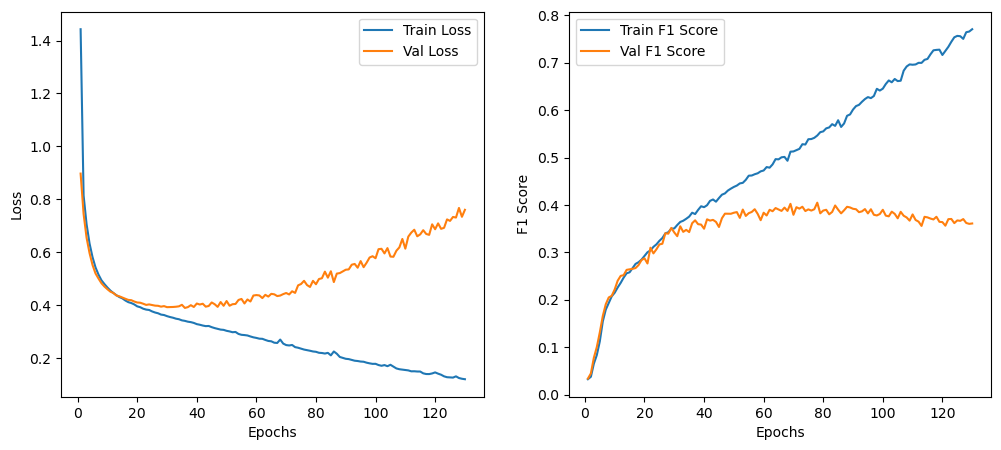

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()